<a href="https://colab.research.google.com/github/a-donat/Benchmarks_PyCaret/blob/main/Predicting_Used_Car_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Set-Up

## I.A. Import Libraries and Download Data

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d milanvaddoriya/old-car-price-prediction
! unzip '/content/old-car-price-prediction.zip' -d '/content/data'

In [ ]:
! pip install pycaret

In [5]:
#import matplotlib.pyplot as plt
#import seaborn as sns
#import VisualizeDataAbbrev as viz

import numpy as np
import pandas as pd
from pycaret.regression import *
from sklearn.model_selection import train_test_split

## I.B. Load Data and Check Data Integrity

In [25]:
ds_df = pd.read_csv("/content/data/car_price.csv")


In [26]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5512 entries, 0 to 5511
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           5512 non-null   int64 
 1   car_name             5512 non-null   object
 2   car_prices_in_rupee  5512 non-null   object
 3   kms_driven           5512 non-null   object
 4   fuel_type            5512 non-null   object
 5   transmission         5512 non-null   object
 6   ownership            5512 non-null   object
 7   manufacture          5512 non-null   int64 
 8   engine               5512 non-null   object
 9   Seats                5512 non-null   object
dtypes: int64(2), object(8)
memory usage: 430.8+ KB


In [27]:
ds_df.nunique()

Unnamed: 0             5512
car_name               1896
car_prices_in_rupee    1300
kms_driven             2610
fuel_type                 5
transmission              2
ownership                 6
manufacture              26
engine                  139
Seats                     6
dtype: int64


# II. Preprocessing

In [28]:
ds_df.head()

,Unnamed: 0,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,0,Jeep Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats
1,1,Renault Duster RXZ Turbo CVT,12.83 Lakh,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats
2,2,Toyota Camry 2.5 G,16.40 Lakh,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats
3,3,Honda Jazz VX CVT,7.77 Lakh,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats
4,4,Volkswagen Polo 1.2 MPI Highline,5.15 Lakh,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats


In [37]:
ds_df[["raw_price", "price_currency"]] = ds_df["car_prices_in_rupee"].str.split(
    " ", expand=True)

In [38]:
ds_df["raw_price"] = ds_df["raw_price"].apply(
    lambda x: x.replace(",", "")).astype(float)

1 Crore = 100 Lakhs<br>
1 Lakh = 100,000 rupees

In [40]:
ds_df["price_currency"].unique()

array(['Lakh', 'Crore', ''], dtype=object)

In [41]:
ds_df["currency_mult"] = ds_df["price_currency"].map(
    {"": 1, "Lakh": 100000, "Crore": 100*100000})

In [42]:
ds_df["price"] = ds_df["raw_price"] * ds_df["currency_mult"]

In [32]:
ds_df["price_currency"].value_counts()

Lakh     5333
          123
Crore      56
Name: price_currency, dtype: int64

In [31]:
ds_df["kms_driven"] = ds_df["kms_driven"].apply(
    lambda x: x.replace(" kms", "").replace(",", "")).astype(int)

In [43]:
ds_df["ownership"].value_counts()

1st Owner    3736
2nd Owner    1314
3rd Owner     359
4th Owner      84
5th Owner      12
0th Owner       7
Name: ownership, dtype: int64

In [44]:
ds_df["ownership"] = ds_df["ownership"].str[0].astype(int)

In [45]:
ds_df["transmission"].value_counts()

Manual       3962
Automatic    1550
Name: transmission, dtype: int64

In [47]:
ds_df["transmission"] = ds_df["transmission"].replace(
    {"Manual": 0, "Automatic": 1})

In [49]:
ds_df["engine"].str[-3:].unique()

array([' cc'], dtype=object)

In [50]:
ds_df["engine"] = ds_df["engine"].apply(
    lambda x: x.replace(" cc", "")).astype(int)

In [52]:
ds_df["Seats"].value_counts()

5 Seats    4673
7 Seats     631
4 Seats      88
6 Seats      61
8 Seats      54
2 Seats       5
Name: Seats, dtype: int64

In [53]:
ds_df["Seats"] = ds_df["Seats"].str[0].astype(int)

In [55]:
ds_df["car_name"].str.split(
    " ", expand=True)[0].nunique()

32

In [60]:
ds_df["car_brand"] = ds_df["car_name"].str.split(
    " ", expand=True)[0]

In [61]:
ds_df["car_brand"].value_counts()

Maruti           1389
Hyundai          1023
Honda             498
Mahindra          315
Mercedes-Benz     283
Tata              269
Toyota            263
BMW               172
Renault           170
Ford              168
Audi              166
Volkswagen        159
Skoda             113
Chevrolet          82
Nissan             63
MG                 62
Kia                61
Land               50
Jeep               49
Volvo              31
Jaguar             30
Datsun             25
Fiat               17
Mini               14
Porsche            10
Lexus              10
Mitsubishi          8
Maserati            5
Isuzu               4
Force               1
Premier             1
Bentley             1
Name: car_brand, dtype: int64

In [80]:
ds_df["car_brand_mod"] = ds_df["car_brand"].replace(
    {b: "other" for b in ["Isuzu", "Force", "Premier", "Bentley"]})

In [84]:
ds_df["car_brand_mod"].nunique()

29

In [79]:
ds_df["fuel_type"].value_counts()

Petrol      2967
Diesel      2423
Cng           80
Lpg           28
Electric      14
Name: fuel_type, dtype: int64

In [59]:
import seaborn as sns

<Axes: xlabel='car_brand', ylabel='price'>

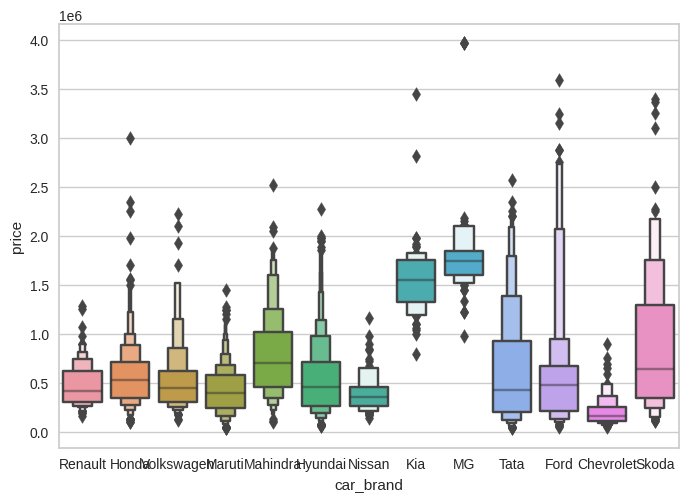

In [74]:
sns.boxenplot(data=ds_df[ds_df["car_brand"].isin(
    ["Maruti", "Hyundai", "Honda", "Mahindra", "Tata", "Renault", "Ford",
     "Volkswagen", "Skoda", "Chevrolet", "Nissan", "MG", "Kia"])],
              x="car_brand", y="price")

<Axes: xlabel='car_brand', ylabel='price'>

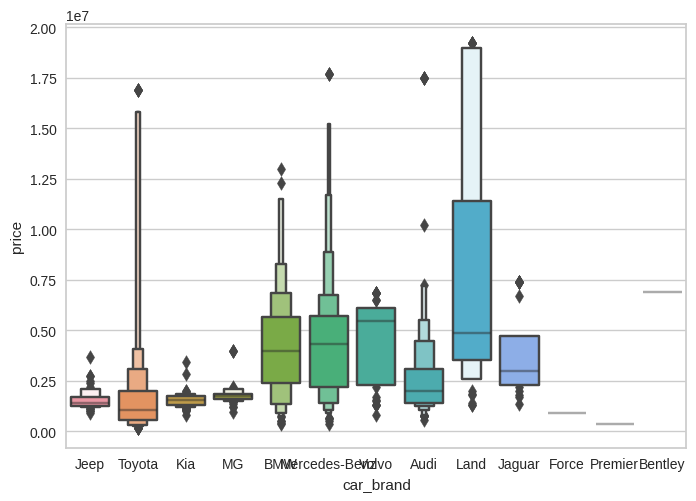

In [75]:
sns.boxenplot(data=ds_df[ds_df["car_brand"].isin(
    ["Toyota", "BMW", "Mercedes-Benz", "Audi", "Jeep", "Jaguar", "Land",
     "Volvo", "Force", "Premier", "Bentley", "MG", "Kia"])],
              x="car_brand", y="price")

In [58]:
ds_df["car_name"].str.split(
    " ", expand=True)[1].value_counts()

Swift        388
i20          237
City         221
Wagon        206
Alto         192
            ... 
Outlander      1
Fusion         1
Supro          1
Aria           1
M              1
Name: 1, Length: 230, dtype: int64

In [82]:
list(ds_df)

['Unnamed: 0',
 'car_name',
 'car_prices_in_rupee',
 'kms_driven',
 'fuel_type',
 'transmission',
 'ownership',
 'manufacture',
 'engine',
 'Seats',
 'price_currency',
 'raw_price',
 'currency_mult',
 'price',
 'car_brand',
 'car_brand_mod']

In [83]:
ds_df[['kms_driven',
 'transmission',
 'ownership',
 'manufacture',
 'engine',
 'Seats',
 'price']].corr().round(2)

,kms_driven,transmission,ownership,manufacture,engine,Seats,price
kms_driven,1.00,-0.21,0.28,-0.48,-0.03,0.02,-0.24
transmission,-0.21,1.00,-0.08,0.26,0.18,-0.01,0.53
ownership,0.28,-0.08,1.00,-0.43,-0.02,-0.00,-0.16
manufacture,-0.48,0.26,-0.43,1.00,0.06,0.01,0.35
engine,-0.03,0.18,-0.02,0.06,1.00,0.14,0.16
Seats,0.02,-0.01,-0.00,0.01,0.14,1.00,0.01
price,-0.24,0.53,-0.16,0.35,0.16,0.01,1.00


In [85]:
train_df, test_df = train_test_split(
    ds_df, test_size=0.20, random_state=1)

# III. Create Models

In [86]:
reg_models = setup(
    data=train_df, target='price', session_id=123,
    ignore_features=['Unnamed: 0', 'car_name', 'car_prices_in_rupee',
                     'price_currency', 'raw_price', 'currency_mult', 'car_brand'])


,Description,Value
0,Session id,123
1,Target,price
2,Target type,Regression
3,Original data shape,"(4409, 16)"
4,Transformed data shape,"(4409, 13)"
5,Transformed train set shape,"(3086, 13)"
6,Transformed test set shape,"(1323, 13)"
7,Ignore features,7
8,Numeric features,6
9,Categorical features,2


In [87]:
best_model = compare_models(fold=5)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,293762.3321,575722708817.5192,754160.9905,0.8536,0.3708,0.3181,1.3600
xgboost,Extreme Gradient Boosting,312599.8250,598381756416.0000,772929.7375,0.8475,0.4102,0.3377,0.4280
rf,Random Forest Regressor,335815.3098,791178392832.0305,887768.2657,0.7990,0.3750,0.3304,0.9620
lightgbm,Light Gradient Boosting Machine,368940.7580,854448260370.5012,922810.4179,0.7825,0.4128,0.3565,0.4260
gbr,Gradient Boosting Regressor,368676.0831,879007597520.8047,930103.4809,0.7791,0.4288,0.3842,0.4600
knn,K Neighbors Regressor,503031.1312,1260233529753.6001,1118966.3875,0.6847,0.6615,0.7193,0.1880
dt,Decision Tree Regressor,402853.1159,1618185409933.0254,1243126.2059,0.6003,0.4816,0.4020,0.1640
llar,Lasso Least Angle Regression,613964.8740,1896741808329.8423,1372436.8828,0.5265,0.8217,1.0055,0.2220
ridge,Ridge Regression,613740.3358,1896740029588.9812,1372438.1779,0.5265,0.8151,1.0050,0.1620
lasso,Lasso Regression,613964.9422,1896741887845.6165,1372436.9093,0.5265,0.8217,1.0055,0.1740


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

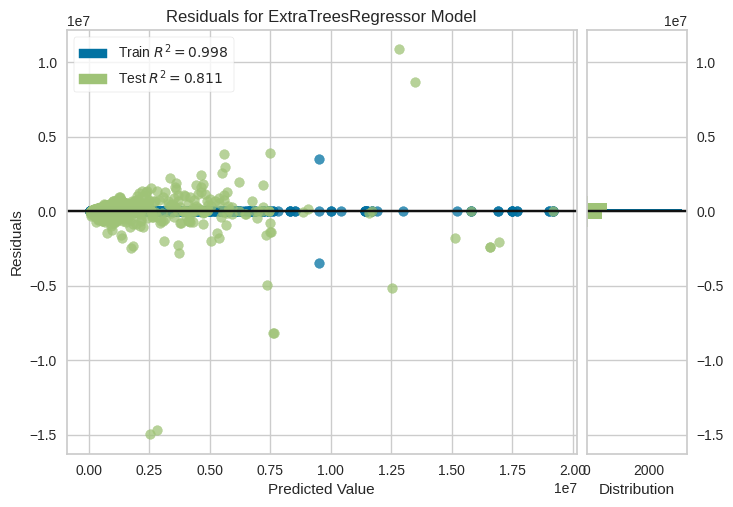

In [88]:
plot_model(best_model)

In [92]:
reg_models2 = setup(
    data=train_df, target='price', session_id=124, max_encoding_ohe=30,
    ignore_features=['Unnamed: 0', 'car_name', 'car_prices_in_rupee',
                     'price_currency', 'raw_price', 'currency_mult', 'car_brand'])

,Description,Value
0,Session id,124
1,Target,price
2,Target type,Regression
3,Original data shape,"(4409, 16)"
4,Transformed data shape,"(4409, 41)"
5,Transformed train set shape,"(3086, 41)"
6,Transformed test set shape,"(1323, 41)"
7,Ignore features,7
8,Numeric features,6
9,Categorical features,2


In [93]:
reg_models2._fxs["Categorical"]

['fuel_type', 'car_brand_mod']

In [94]:
best_model2 = compare_models(fold=5)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,338432.1188,942201339904.0000,929329.5375,0.7779,0.4237,0.3513,0.7800
et,Extra Trees Regressor,302260.6572,948922338884.1042,926031.7199,0.7748,0.3795,0.3160,1.4500
rf,Random Forest Regressor,339590.0088,983643471688.4207,951749.7964,0.7643,0.3864,0.3399,1.1900
gbr,Gradient Boosting Regressor,404645.7048,1229175682373.1792,1075611.0447,0.7015,0.4653,0.4353,0.5040
lightgbm,Light Gradient Boosting Machine,466313.4001,1341138177930.8293,1131404.0355,0.6705,0.5767,0.4759,0.7840
ridge,Ridge Regression,564478.4450,1755199702274.4380,1291571.5625,0.5717,0.8248,0.9606,0.1560
lr,Linear Regression,560851.7388,1757123818483.8804,1292632.6518,0.5706,0.8081,0.9546,1.5140
lasso,Lasso Regression,560853.1488,1757122434606.9714,1292631.7085,0.5706,0.8080,0.9546,0.3180
llar,Lasso Least Angle Regression,560851.4724,1757121617975.4556,1292631.2867,0.5706,0.8080,0.9546,0.1580
lar,Least Angle Regression,565165.5596,1773296214838.9453,1300772.7451,0.5650,0.8142,0.9728,0.1620


Processing:   0%|          | 0/81 [00:00<?, ?it/s]